# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.25].
$$

In [1]:
NAME = "3_1e-12_2"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [512]*4 + [2] # (x, t) -> (u, v)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.25]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1e-12

@jax.jit
def model(params, xt): # for predictions
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(dv_dt_c + 1/epsilon*du_dx_c, -1/epsilon*v_c)
# 		loss_c = loss_c1 + loss_c2
	else:
		loss_c1 = loss_c2 = 0
# 		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c1, loss_c2, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d, loss_c1, loss_c2, loss_d, l1, l2

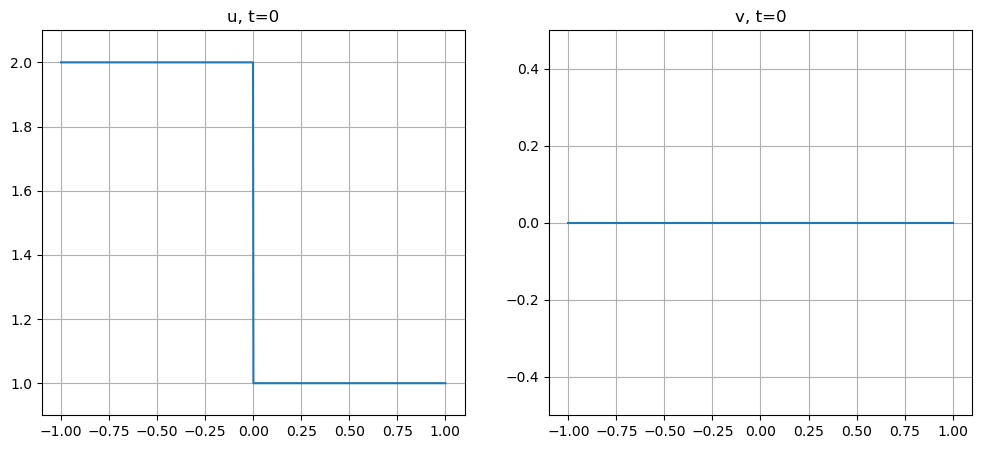

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 500
n_ct = 500
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-4
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 1000, "collocation": 20000}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 500000
print_every = 1000
save_every = 10000
weights = {"c1": 1.0, "c2": epsilon, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/22, 10:16:35, Iteration: 0, Train Loss: 1.6196e+02, c1: 1.4259e-01, c2: 7.4496e+10, d: 1.6174e+00, l1_reg: 1.7756e+04, l2_reg: 6.8303e+02
2020/08/22, 10:17:38, Iteration: 1000, Train Loss: 9.1195e+00, c1: 6.5194e-02, c2: 5.1547e+11, d: 8.5389e-02, l1_reg: 1.7812e+04, l2_reg: 6.8668e+02
2020/08/22, 10:18:34, Iteration: 2000, Train Loss: 5.7686e+00, c1: 2.5178e-02, c2: 6.3750e+11, d: 5.1060e-02, l1_reg: 1.7806e+04, l2_reg: 6.8630e+02
2020/08/22, 10:19:27, Iteration: 3000, Train Loss: 6.7471e+00, c1: 5.1503e-02, c2: 6.0952e+11, d: 6.0861e-02, l1_reg: 1.7802e+04, l2_reg: 6.8599e+02
2020/08/22, 10:20:17, Iteration: 4000, Train Loss: 5.2972e+00, c1: 2.9372e-02, c2: 6.2828e+11, d: 4.6395e-02, l1_reg: 1.7803e+04, l2_reg: 6.8644e+02
2020/08/22, 10:21:06, Iteration: 5000, Train Loss: 4.3759e+00, c1: 7.3762e-03, c2: 6.3425e+11, d: 3.7343e-02, l1_reg: 1.7805e+04, l2_reg: 6.8664e+02
2020/08/22, 10:21:54, Iteration: 6000, Train Loss: 4.8759e+00, c1: 8.7824e-03, c2: 6.3388e+11, d: 4.2333e-02,

2020/08/22, 10:59:58, Iteration: 55000, Train Loss: 2.5116e+00, c1: 2.7748e-03, c2: 5.7481e+11, d: 1.9340e-02, l1_reg: 1.6681e+04, l2_reg: 6.7563e+02
2020/08/22, 11:00:44, Iteration: 56000, Train Loss: 2.4777e+00, c1: 2.4463e-03, c2: 5.9236e+11, d: 1.8829e-02, l1_reg: 1.6664e+04, l2_reg: 6.7764e+02
2020/08/22, 11:01:31, Iteration: 57000, Train Loss: 2.6961e+00, c1: 2.5326e-03, c2: 5.9866e+11, d: 2.0949e-02, l1_reg: 1.6634e+04, l2_reg: 6.7777e+02
2020/08/22, 11:02:17, Iteration: 58000, Train Loss: 2.7071e+00, c1: 4.3574e-03, c2: 5.9490e+11, d: 2.1079e-02, l1_reg: 1.6614e+04, l2_reg: 6.7741e+02
2020/08/22, 11:03:03, Iteration: 59000, Train Loss: 2.8123e+00, c1: 3.1951e-03, c2: 6.0038e+11, d: 2.2088e-02, l1_reg: 1.6602e+04, l2_reg: 6.7762e+02
2020/08/22, 11:03:50, Iteration: 60000, Train Loss: 2.7708e+00, c1: 2.2004e-03, c2: 5.8927e+11, d: 2.1793e-02, l1_reg: 1.6578e+04, l2_reg: 6.7737e+02
2020/08/22, 11:04:36, Iteration: 61000, Train Loss: 2.4458e+00, c1: 2.5132e-03, c2: 5.9711e+11, d: 1

2020/08/22, 11:42:32, Iteration: 110000, Train Loss: 1.8527e+00, c1: 1.5536e-03, c2: 5.7500e+11, d: 1.2761e-02, l1_reg: 1.4988e+04, l2_reg: 6.5428e+02
2020/08/22, 11:43:19, Iteration: 111000, Train Loss: 2.3035e+00, c1: 6.5579e-03, c2: 5.7781e+11, d: 1.7192e-02, l1_reg: 1.4954e+04, l2_reg: 6.5386e+02
2020/08/22, 11:44:05, Iteration: 112000, Train Loss: 1.7987e+00, c1: 1.3505e-03, c2: 5.7428e+11, d: 1.2230e-02, l1_reg: 1.4930e+04, l2_reg: 6.5388e+02
2020/08/22, 11:44:51, Iteration: 113000, Train Loss: 1.8976e+00, c1: 1.4292e-03, c2: 5.7304e+11, d: 1.3232e-02, l1_reg: 1.4903e+04, l2_reg: 6.5366e+02
2020/08/22, 11:45:37, Iteration: 114000, Train Loss: 1.8874e+00, c1: 1.3472e-03, c2: 5.7302e+11, d: 1.3131e-02, l1_reg: 1.4875e+04, l2_reg: 6.5356e+02
2020/08/22, 11:46:24, Iteration: 115000, Train Loss: 1.9711e+00, c1: 3.5588e-03, c2: 5.7216e+11, d: 1.3954e-02, l1_reg: 1.4849e+04, l2_reg: 6.5360e+02
2020/08/22, 11:47:10, Iteration: 116000, Train Loss: 2.0894e+00, c1: 1.5326e-03, c2: 5.7604e+1

2020/08/22, 12:25:05, Iteration: 165000, Train Loss: 1.7831e+00, c1: 1.3511e-03, c2: 5.6461e+11, d: 1.2171e-02, l1_reg: 1.3886e+04, l2_reg: 6.4393e+02
2020/08/22, 12:25:52, Iteration: 166000, Train Loss: 1.6911e+00, c1: 1.5643e-03, c2: 5.6256e+11, d: 1.1269e-02, l1_reg: 1.3884e+04, l2_reg: 6.4424e+02
2020/08/22, 12:26:38, Iteration: 167000, Train Loss: 1.6435e+00, c1: 1.0665e-03, c2: 5.6306e+11, d: 1.0794e-02, l1_reg: 1.3862e+04, l2_reg: 6.4429e+02
2020/08/22, 12:27:25, Iteration: 168000, Train Loss: 1.5609e+00, c1: 1.2092e-03, c2: 5.6259e+11, d: 9.9706e-03, l1_reg: 1.3839e+04, l2_reg: 6.4404e+02
2020/08/22, 12:28:12, Iteration: 169000, Train Loss: 1.5902e+00, c1: 1.6024e-03, c2: 5.6487e+11, d: 1.0238e-02, l1_reg: 1.3827e+04, l2_reg: 6.4392e+02
2020/08/22, 12:28:58, Iteration: 170000, Train Loss: 1.5928e+00, c1: 1.2170e-03, c2: 5.5941e+11, d: 1.0322e-02, l1_reg: 1.3803e+04, l2_reg: 6.4359e+02
2020/08/22, 12:29:45, Iteration: 171000, Train Loss: 1.5220e+00, c1: 1.2751e-03, c2: 5.5934e+1

2020/08/22, 13:07:46, Iteration: 220000, Train Loss: 1.8283e+00, c1: 2.6642e-03, c2: 5.5156e+11, d: 1.2741e-02, l1_reg: 1.2860e+04, l2_reg: 6.3217e+02
2020/08/22, 13:08:33, Iteration: 221000, Train Loss: 1.4572e+00, c1: 1.9302e-03, c2: 5.5168e+11, d: 9.0358e-03, l1_reg: 1.2839e+04, l2_reg: 6.3241e+02
2020/08/22, 13:09:19, Iteration: 222000, Train Loss: 1.5582e+00, c1: 1.3896e-03, c2: 5.5109e+11, d: 1.0057e-02, l1_reg: 1.2814e+04, l2_reg: 6.3237e+02
2020/08/22, 13:10:06, Iteration: 223000, Train Loss: 1.4071e+00, c1: 9.6183e-04, c2: 5.5832e+11, d: 8.4777e-03, l1_reg: 1.2795e+04, l2_reg: 6.3228e+02
2020/08/22, 13:10:52, Iteration: 224000, Train Loss: 1.5205e+00, c1: 1.5893e-03, c2: 5.4997e+11, d: 9.6896e-03, l1_reg: 1.2781e+04, l2_reg: 6.3218e+02
2020/08/22, 13:11:39, Iteration: 225000, Train Loss: 1.3519e+00, c1: 8.3513e-04, c2: 5.4790e+11, d: 8.0320e-03, l1_reg: 1.2760e+04, l2_reg: 6.3190e+02
2020/08/22, 13:12:25, Iteration: 226000, Train Loss: 1.2784e+00, c1: 9.7106e-04, c2: 5.4829e+1

2020/08/22, 13:50:29, Iteration: 275000, Train Loss: 1.1921e+00, c1: 8.2821e-04, c2: 5.4425e+11, d: 6.4706e-03, l1_reg: 1.2143e+04, l2_reg: 6.3387e+02
2020/08/22, 13:51:15, Iteration: 276000, Train Loss: 1.4567e+00, c1: 2.6122e-03, c2: 5.5719e+11, d: 8.9690e-03, l1_reg: 1.2148e+04, l2_reg: 6.3418e+02
2020/08/22, 13:52:02, Iteration: 277000, Train Loss: 1.2898e+00, c1: 1.1866e-03, c2: 5.4171e+11, d: 7.4692e-03, l1_reg: 1.2120e+04, l2_reg: 6.3437e+02
2020/08/22, 13:52:48, Iteration: 278000, Train Loss: 1.3400e+00, c1: 2.6070e-03, c2: 5.4393e+11, d: 7.9342e-03, l1_reg: 1.2125e+04, l2_reg: 6.3479e+02
2020/08/22, 13:53:35, Iteration: 279000, Train Loss: 1.2262e+00, c1: 8.4111e-04, c2: 5.4578e+11, d: 6.7956e-03, l1_reg: 1.2108e+04, l2_reg: 6.3503e+02
2020/08/22, 13:54:21, Iteration: 280000, Train Loss: 1.2960e+00, c1: 1.0813e-03, c2: 5.4316e+11, d: 7.5177e-03, l1_reg: 1.2079e+04, l2_reg: 6.3521e+02
2020/08/22, 13:55:08, Iteration: 281000, Train Loss: 1.2089e+00, c1: 8.1002e-04, c2: 5.4246e+1

2020/08/22, 14:33:03, Iteration: 330000, Train Loss: 1.0817e+00, c1: 8.9547e-04, c2: 5.4314e+11, d: 5.3768e-03, l1_reg: 1.1633e+04, l2_reg: 6.5081e+02
2020/08/22, 14:33:50, Iteration: 331000, Train Loss: 1.1400e+00, c1: 1.1683e-03, c2: 5.4445e+11, d: 5.9436e-03, l1_reg: 1.1615e+04, l2_reg: 6.5096e+02
2020/08/22, 14:34:36, Iteration: 332000, Train Loss: 1.0974e+00, c1: 8.7956e-04, c2: 5.3962e+11, d: 5.5686e-03, l1_reg: 1.1624e+04, l2_reg: 6.5116e+02
2020/08/22, 14:35:23, Iteration: 333000, Train Loss: 1.1399e+00, c1: 8.7037e-04, c2: 5.4044e+11, d: 5.9860e-03, l1_reg: 1.1599e+04, l2_reg: 6.5122e+02
2020/08/22, 14:36:09, Iteration: 334000, Train Loss: 1.1246e+00, c1: 8.7831e-04, c2: 5.3919e+11, d: 5.8456e-03, l1_reg: 1.1601e+04, l2_reg: 6.5148e+02
2020/08/22, 14:36:55, Iteration: 335000, Train Loss: 1.1776e+00, c1: 1.0644e-03, c2: 5.4100e+11, d: 6.3551e-03, l1_reg: 1.1615e+04, l2_reg: 6.5188e+02
2020/08/22, 14:37:42, Iteration: 336000, Train Loss: 1.1363e+00, c1: 7.3726e-04, c2: 5.4063e+1

2020/08/22, 15:15:31, Iteration: 385000, Train Loss: 1.0053e+00, c1: 1.4086e-03, c2: 5.4649e+11, d: 4.5744e-03, l1_reg: 1.1215e+04, l2_reg: 6.4787e+02
2020/08/22, 15:16:17, Iteration: 386000, Train Loss: 1.1435e+00, c1: 1.1128e-03, c2: 5.4439e+11, d: 5.9802e-03, l1_reg: 1.1205e+04, l2_reg: 6.4765e+02
2020/08/22, 15:17:03, Iteration: 387000, Train Loss: 1.2673e+00, c1: 1.5979e-03, c2: 5.4731e+11, d: 7.1839e-03, l1_reg: 1.1168e+04, l2_reg: 6.4728e+02
2020/08/22, 15:17:50, Iteration: 388000, Train Loss: 1.1078e+00, c1: 1.0368e-03, c2: 5.4987e+11, d: 5.5686e-03, l1_reg: 1.1161e+04, l2_reg: 6.4710e+02
2020/08/22, 15:18:36, Iteration: 389000, Train Loss: 1.1041e+00, c1: 1.6996e-03, c2: 5.4464e+11, d: 5.5777e-03, l1_reg: 1.1192e+04, l2_reg: 6.4710e+02
2020/08/22, 15:19:23, Iteration: 390000, Train Loss: 1.0604e+00, c1: 8.7586e-04, c2: 5.4693e+11, d: 5.1257e-03, l1_reg: 1.1175e+04, l2_reg: 6.4689e+02
2020/08/22, 15:20:09, Iteration: 391000, Train Loss: 1.0368e+00, c1: 9.5659e-04, c2: 5.4468e+1

2020/08/22, 15:58:03, Iteration: 440000, Train Loss: 1.0630e+00, c1: 8.6980e-04, c2: 5.4468e+11, d: 5.1743e-03, l1_reg: 1.0799e+04, l2_reg: 6.3483e+02
2020/08/22, 15:58:49, Iteration: 441000, Train Loss: 1.0814e+00, c1: 1.0382e-03, c2: 5.4535e+11, d: 5.3501e-03, l1_reg: 1.0819e+04, l2_reg: 6.3483e+02
2020/08/22, 15:59:36, Iteration: 442000, Train Loss: 1.0669e+00, c1: 9.5338e-04, c2: 5.4302e+11, d: 5.2296e-03, l1_reg: 1.0787e+04, l2_reg: 6.3451e+02
2020/08/22, 16:00:22, Iteration: 443000, Train Loss: 1.0456e+00, c1: 1.1144e-03, c2: 5.4391e+11, d: 5.0056e-03, l1_reg: 1.0796e+04, l2_reg: 6.3433e+02
2020/08/22, 16:01:09, Iteration: 444000, Train Loss: 1.0999e+00, c1: 1.2180e-03, c2: 5.4337e+11, d: 5.5530e-03, l1_reg: 1.0801e+04, l2_reg: 6.3414e+02
2020/08/22, 16:01:55, Iteration: 445000, Train Loss: 1.0903e+00, c1: 1.2888e-03, c2: 5.4532e+11, d: 5.4365e-03, l1_reg: 1.0792e+04, l2_reg: 6.3407e+02
2020/08/22, 16:02:41, Iteration: 446000, Train Loss: 1.0472e+00, c1: 8.1547e-04, c2: 5.4429e+1

2020/08/22, 16:40:34, Iteration: 495000, Train Loss: 1.0900e+00, c1: 1.0553e-03, c2: 5.3722e+11, d: 5.5175e-03, l1_reg: 1.0454e+04, l2_reg: 6.2702e+02
2020/08/22, 16:41:21, Iteration: 496000, Train Loss: 1.1083e+00, c1: 6.2923e-04, c2: 5.3773e+11, d: 5.6999e-03, l1_reg: 1.0408e+04, l2_reg: 6.2669e+02
2020/08/22, 16:42:07, Iteration: 497000, Train Loss: 1.0468e+00, c1: 9.1954e-04, c2: 5.3928e+11, d: 5.0658e-03, l1_reg: 1.0422e+04, l2_reg: 6.2660e+02
2020/08/22, 16:42:53, Iteration: 498000, Train Loss: 1.0350e+00, c1: 1.2068e-03, c2: 5.3683e+11, d: 4.9699e-03, l1_reg: 1.0414e+04, l2_reg: 6.2650e+02
2020/08/22, 16:43:40, Iteration: 499000, Train Loss: 1.0126e+00, c1: 7.4947e-04, c2: 5.3923e+11, d: 4.7261e-03, l1_reg: 1.0373e+04, l2_reg: 6.2620e+02
2020/08/22, 16:44:26, Iteration: 500000, Train Loss: 1.0987e+00, c1: 8.9952e-04, c2: 5.3741e+11, d: 5.6037e-03, l1_reg: 1.0401e+04, l2_reg: 6.2611e+02


In [8]:
start_iteration = 50000
iterations = 200000
print_every = 1000
save_every = 10000
weights = {"c1": 1.0, "c2": epsilon, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/22, 16:44:26, Iteration: 50000, Train Loss: 1.0823e+00, c1: 7.6723e-04, c2: 5.3675e+11, d: 5.4476e-03, l1_reg: 1.0401e+04, l2_reg: 6.2611e+02
2020/08/22, 16:45:13, Iteration: 51000, Train Loss: 1.0556e+00, c1: 7.1695e-04, c2: 5.3808e+11, d: 5.1677e-03, l1_reg: 1.0391e+04, l2_reg: 6.2593e+02
2020/08/22, 16:45:59, Iteration: 52000, Train Loss: 1.6219e+00, c1: 1.4792e-03, c2: 5.4035e+11, d: 1.0801e-02, l1_reg: 1.0386e+04, l2_reg: 6.2580e+02
2020/08/22, 16:46:46, Iteration: 53000, Train Loss: 1.0515e+00, c1: 1.0721e-03, c2: 5.3883e+11, d: 5.1157e-03, l1_reg: 1.0361e+04, l2_reg: 6.2558e+02
2020/08/22, 16:47:32, Iteration: 54000, Train Loss: 1.0294e+00, c1: 7.7053e-04, c2: 5.4230e+11, d: 4.8631e-03, l1_reg: 1.0381e+04, l2_reg: 6.2564e+02
2020/08/22, 16:48:18, Iteration: 55000, Train Loss: 1.0641e+00, c1: 1.0019e-03, c2: 5.3724e+11, d: 5.2584e-03, l1_reg: 1.0374e+04, l2_reg: 6.2545e+02
2020/08/22, 16:49:05, Iteration: 56000, Train Loss: 1.0478e+00, c1: 1.0457e-03, c2: 5.3714e+11, d: 5

2020/08/22, 17:26:59, Iteration: 105000, Train Loss: 1.0317e+00, c1: 8.4462e-04, c2: 5.3227e+11, d: 4.9864e-03, l1_reg: 1.0086e+04, l2_reg: 6.1803e+02
2020/08/22, 17:27:45, Iteration: 106000, Train Loss: 9.8293e-01, c1: 1.0227e-03, c2: 5.3336e+11, d: 4.4855e-03, l1_reg: 1.0075e+04, l2_reg: 6.1780e+02
2020/08/22, 17:28:31, Iteration: 107000, Train Loss: 1.0216e+00, c1: 1.0418e-03, c2: 5.3198e+11, d: 4.8861e-03, l1_reg: 1.0098e+04, l2_reg: 6.1773e+02
2020/08/22, 17:29:18, Iteration: 108000, Train Loss: 1.1059e+00, c1: 7.6845e-04, c2: 5.4298e+11, d: 5.6215e-03, l1_reg: 1.0067e+04, l2_reg: 6.1748e+02
2020/08/22, 17:30:04, Iteration: 109000, Train Loss: 9.5833e-01, c1: 8.7392e-04, c2: 5.3698e+11, d: 4.2048e-03, l1_reg: 1.0129e+04, l2_reg: 6.1762e+02
2020/08/22, 17:30:51, Iteration: 110000, Train Loss: 9.5539e-01, c1: 9.5378e-04, c2: 5.3319e+11, d: 4.2125e-03, l1_reg: 1.0076e+04, l2_reg: 6.1733e+02
2020/08/22, 17:31:37, Iteration: 111000, Train Loss: 1.0813e+00, c1: 1.3824e-03, c2: 5.3448e+1

2020/08/22, 18:09:32, Iteration: 160000, Train Loss: 1.0217e+00, c1: 6.5990e-04, c2: 5.3574e+11, d: 4.8534e-03, l1_reg: 9.7922e+03, l2_reg: 6.0881e+02
2020/08/22, 18:10:18, Iteration: 161000, Train Loss: 1.0016e+00, c1: 7.8859e-04, c2: 5.4757e+11, d: 4.5325e-03, l1_reg: 9.7771e+03, l2_reg: 6.0859e+02
2020/08/22, 18:11:04, Iteration: 162000, Train Loss: 9.2767e-01, c1: 7.7463e-04, c2: 5.3577e+11, d: 3.9113e-03, l1_reg: 9.7523e+03, l2_reg: 6.0830e+02
2020/08/22, 18:11:51, Iteration: 163000, Train Loss: 1.0065e+00, c1: 6.6334e-04, c2: 5.3724e+11, d: 4.6855e-03, l1_reg: 9.7983e+03, l2_reg: 6.0820e+02
2020/08/22, 18:12:37, Iteration: 164000, Train Loss: 1.0106e+00, c1: 1.1313e-03, c2: 5.3790e+11, d: 4.7155e-03, l1_reg: 9.7346e+03, l2_reg: 6.0784e+02
2020/08/22, 18:13:24, Iteration: 165000, Train Loss: 1.1680e+00, c1: 1.0155e-03, c2: 5.3747e+11, d: 6.2947e-03, l1_reg: 9.8050e+03, l2_reg: 6.0787e+02
2020/08/22, 18:14:10, Iteration: 166000, Train Loss: 1.0291e+00, c1: 5.8886e-04, c2: 5.3539e+1

2020/08/22, 18:54:26, Iteration: 218000, Train Loss: 9.6047e-01, c1: 1.2834e-03, c2: 5.3336e+11, d: 4.2582e-03, l1_reg: 9.4710e+03, l2_reg: 5.9751e+02
2020/08/22, 18:55:12, Iteration: 219000, Train Loss: 9.6855e-01, c1: 5.9850e-04, c2: 5.3284e+11, d: 4.3511e-03, l1_reg: 9.4257e+03, l2_reg: 5.9717e+02
2020/08/22, 18:55:59, Iteration: 220000, Train Loss: 9.9860e-01, c1: 7.2812e-04, c2: 5.3298e+11, d: 4.6489e-03, l1_reg: 9.4554e+03, l2_reg: 5.9701e+02
2020/08/22, 18:56:45, Iteration: 221000, Train Loss: 1.0019e+00, c1: 6.4492e-04, c2: 5.3470e+11, d: 4.6651e-03, l1_reg: 9.4385e+03, l2_reg: 5.9678e+02
2020/08/22, 18:57:32, Iteration: 222000, Train Loss: 9.7305e-01, c1: 7.1395e-04, c2: 5.3281e+11, d: 4.3953e-03, l1_reg: 9.4446e+03, l2_reg: 5.9665e+02
2020/08/22, 18:58:18, Iteration: 223000, Train Loss: 9.5877e-01, c1: 5.3684e-04, c2: 5.3294e+11, d: 4.2530e-03, l1_reg: 9.4435e+03, l2_reg: 5.9647e+02
2020/08/22, 18:59:05, Iteration: 224000, Train Loss: 9.6241e-01, c1: 7.4836e-04, c2: 5.3362e+1

<IPython.core.display.Javascript object>


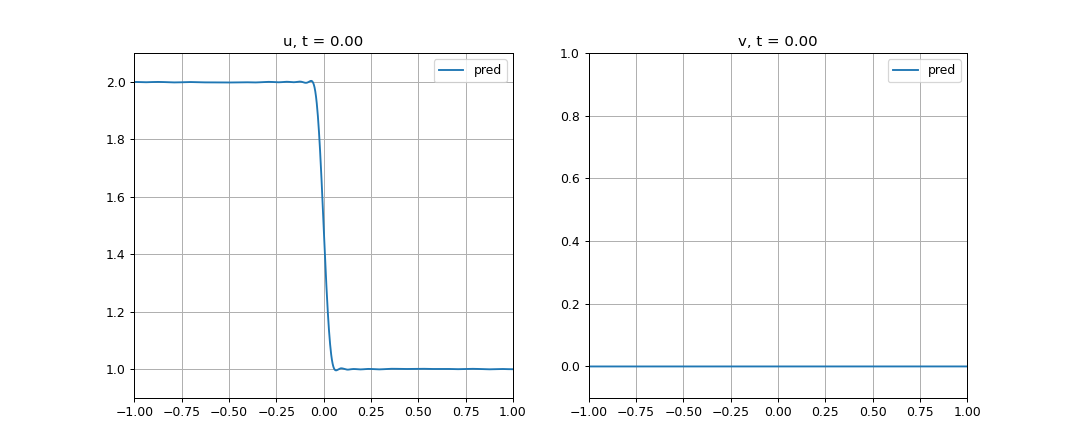

In [10]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
lines = []
for i in range(2):
    line, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.append(line)
    ax[i].set_xlim([-1, 1])
    ax[i].legend()
    ax[i].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[1].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 20, blit = True)
plt.show()

<IPython.core.display.Javascript object>


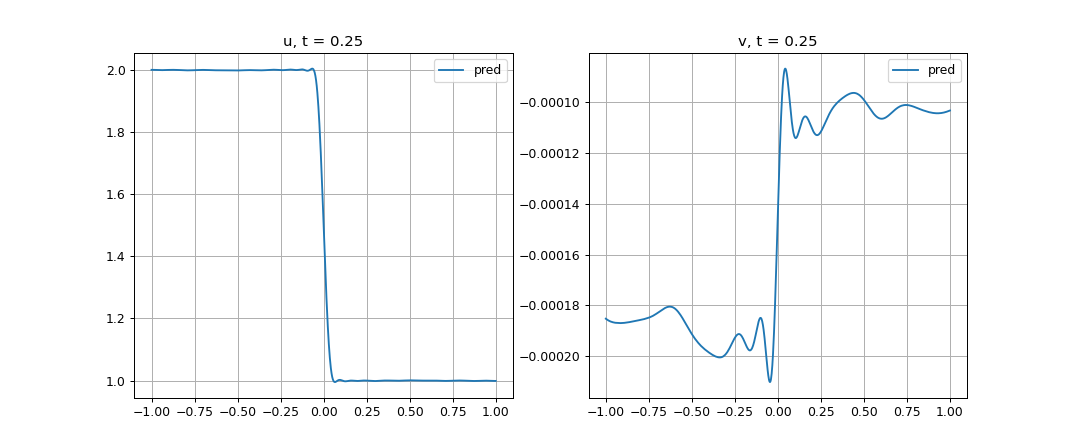

In [11]:
f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].set_title("u, t = {}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].set_title("v, t = {}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))